In [59]:
#Importing packages 

import pandas as pd
import talib
from talib.abstract import *
import matplotlib.pyplot as plt

In [286]:
#testing hourly based data from yahoo finanace
# import yfinance as yf
# from datetime import datetime

# gold = yf.download(tickers="GC=F", period="16y", interval="1d")

# start = datetime(2021, 10, 18, 9, 30, 0)
# end = datetime(2021, 10, 18, 10, 30, 0)

# filtered = gold[start: end]

import yfinance as yf

# Download 1-hour interval data for the S&P 500 index
data = yf.download('^GSPC', interval='1h', start='2004-06-14', end='2004-06-15')

# Display the data
print(data)





[*********************100%***********************]  1 of 1 completed

1 Failed download:
['^GSPC']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1h 2004-06-14 -> 2004-06-15) (Yahoo error = "1h data not available for startTime=1087185600 and endTime=1087272000. The requested range must be within the last 730 days.")')


Empty DataFrame
Columns: [(Adj Close, ^GSPC), (Close, ^GSPC), (High, ^GSPC), (Low, ^GSPC), (Open, ^GSPC), (Volume, ^GSPC)]
Index: []


Data scrapping code has been excluded in this notebook. The focus is more on the implementation of the models and evalation 

## 1. Data Loading 

In [346]:
#dataset of gold fetched from different sources  for different frequencies

gold_data_1h = pd.read_csv("/Users/abhisheksuga/Documents/Edu/thesis/gold/data/Gold_1h.csv")
gold_data_5m = pd.read_csv("/Users/abhisheksuga/Documents/Edu/thesis/gold/data/Gold_5m.csv")
gold_data_15m = pd.read_csv("//Users/abhisheksuga/Documents/Edu/thesis/gold/data/Gold_15m.csv")
gold_data_30m = pd.read_csv("/Users/abhisheksuga/Documents/Edu/thesis/gold/data/Gold_30m.csv")
nasdaq_data = pd.read_csv("/Users/abhisheksuga/Documents/Edu/thesis/gold/data/nasdaq.csv" ,sep='\t')
snp500_data = pd.read_csv("/Users/abhisheksuga/Documents/Edu/thesis/gold/data/snp500.csv",sep='\t')






In [121]:
gold_data_1h.head(38)

,Date,Time,Open,High,Low,Close,Volume
0,2004.06.11,07:00,384.0,384.3,383.3,383.8,44
1,2004.06.11,08:00,383.8,384.3,383.1,383.1,41
2,2004.06.11,09:00,383.1,384.1,382.8,383.1,55
3,2004.06.11,10:00,383.0,383.8,383.0,383.6,33
4,2004.06.11,11:00,383.6,383.8,383.5,383.6,23
5,2004.06.11,12:00,383.5,384.1,383.3,383.3,20
6,2004.06.11,13:00,383.6,384.3,383.6,384.0,15
7,2004.06.11,14:00,383.8,383.8,383.8,383.8,4
8,2004.06.11,15:00,383.8,384.6,383.8,384.6,9
9,2004.06.11,16:00,384.3,384.8,384.1,384.3,19


In [115]:
len(gold_data_1h)
# len(gold_data_5m)

117829

In [116]:
gold_data_1h.isnull().sum()

Date      0
Time      0
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

In [123]:
gold_data_1h.columns

Index(['Date', 'Time', 'Open', 'High', 'Low', 'Close', 'Volume'], dtype='object')

In [124]:
#combining data and time column and ensuring that the data is correctly aligned 
gold_data_1h['DateTime'] = pd.to_datetime(gold_data_1h['Date'] + ' ' + gold_data_1h['Time'])
gold_data_1h.set_index('DateTime', inplace=True)
gold_data_1h.drop(['Date', 'Time'], axis=1, inplace=True)


In [127]:
gold_data_1h.head()
# len(gold_data_1h)

,Open,High,Low,Close,Volume
DateTime,,,,,
2004-06-11 07:00:00,384.0,384.3,383.3,383.8,44
2004-06-11 08:00:00,383.8,384.3,383.1,383.1,41
2004-06-11 09:00:00,383.1,384.1,382.8,383.1,55
2004-06-11 10:00:00,383.0,383.8,383.0,383.6,33
2004-06-11 11:00:00,383.6,383.8,383.5,383.6,23


## 2. Data Preprocessing 

In [141]:
# Filtering  the dataset to include only full days for data consistency
gold_data_1h['Date'] = gold_data_1h.index.normalize()
gold_data_1h['Hour'] = gold_data_1h.index.hour
daily_hours = gold_data_1h.groupby('Date').Hour.nunique()
full_days = daily_hours[daily_hours == 23].index
filtered_data = gold_data_1h[gold_data_1h['Date'].isin(full_days)]


In [284]:
filtered_data.tail(1) # cleared 20k datapoints due to inconsistency
# 2004-06-14
# 2024-09-19 

,Open,High,Low,Close,Volume,Hour,Date
DateTime,,,,,,,
2024-09-19 23:00:00,0.998435,0.995361,0.999112,0.997434,0.059567,23,2024-09-19


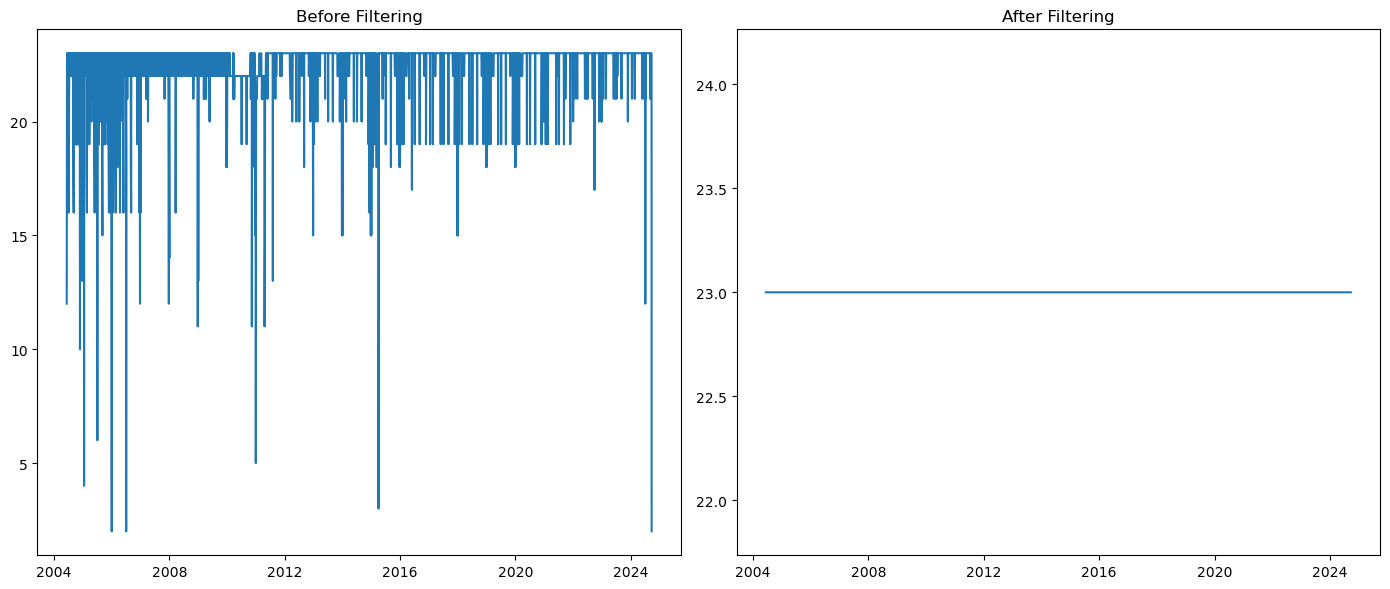

In [146]:
#data comparision of before and after filteriing 
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
gold_data_1h.groupby(gold_data_1h.index.date).size().plot(title='Before Filtering')
plt.subplot(1, 2, 2)
filtered_data.groupby(filtered_data.index.date).size().plot(title='After Filtering')
plt.tight_layout()
plt.show()

In [147]:
#normalising the data 

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
features_to_scale = ['Open', 'High', 'Low', 'Close', 'Volume']
filtered_data[features_to_scale] = scaler.fit_transform(filtered_data[features_to_scale])


/var/folders/bz/q_7jbqjx7hj_vffhkj3cyl_m0000gn/T/ipykernel_11060/859946670.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data[features_to_scale] = scaler.fit_transform(filtered_data[features_to_scale])


In [148]:
print(filtered_data[features_to_scale].describe())


               Open          High           Low         Close        Volume
count  97819.000000  97819.000000  97819.000000  97819.000000  97819.000000
mean       0.436804      0.435821      0.436785      0.436678      0.022161
std        0.213668      0.213191      0.213767      0.213724      0.025929
min        0.000000      0.000000      0.000000      0.000000      0.000000
25%        0.322386      0.321643      0.322391      0.322225      0.005481
50%        0.419190      0.418084      0.419342      0.419070      0.015988
75%        0.612027      0.610582      0.612007      0.611948      0.029705
max        1.000000      1.000000      1.000000      1.000000      1.000000


<Figure size 1000x500 with 0 Axes>

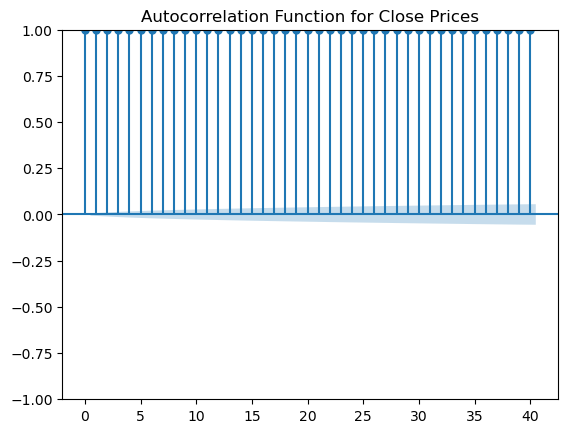

In [150]:
#autocorrelation analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
plt.figure(figsize=(10, 5))
plot_acf(filtered_data['Close'], lags=40, alpha=0.05)  
plt.title('Autocorrelation Function for Close Prices')
plt.show()

In [149]:
#baseline model xg-boost 
import numpy as np
from sklearn.model_selection import train_test_split
import xgboost as xgb




In [162]:
df_1 = filtered_data.copy()  #using it for xgboost , so retaining my original data after filtering 

In [163]:

selected_lags = [1, 3, 10, 20]
for lag in selected_lags:
    df_1[f'Close_lag_{lag}'] = df_1['Close'].shift(lag)

# Calculating rolling statistics based on 23 hour periods
df_1['rolling_mean_close'] = df_1['Close'].rolling(window=23).mean()
df_1['rolling_std_close'] = df_1['Close'].rolling(window=23).std()
df_1.dropna(inplace=True)


In [244]:
df_1.head()

,Open,High,Low,Close,Volume,Hour,Date,Close_lag_1,Close_lag_3,Close_lag_10,Close_lag_20,rolling_mean_close,rolling_std_close
DateTime,,,,,,,,,,,,,
2004-06-14 23:00:00,0.000679,0.000496,0.000680,0.000452,0.000115,23,2004-06-14,0.000362,0.000452,0.000588,0.000362,0.000541,0.000281
2004-06-15 01:00:00,0.000679,0.000586,0.000680,0.000452,0.000060,1,2004-06-15,0.000452,0.000452,0.001131,0.000543,0.000525,0.000275
2004-06-15 02:00:00,0.000905,0.000721,0.000544,0.000679,0.000357,2,2004-06-15,0.000452,0.000362,0.001267,0.000543,0.000531,0.000277
2004-06-15 03:00:00,0.000905,0.000812,0.000634,0.000317,0.000278,3,2004-06-15,0.000679,0.000452,0.001041,0.000452,0.000529,0.000278
2004-06-15 04:00:00,0.000452,0.000361,0.000453,0.000362,0.000199,4,2004-06-15,0.000317,0.000452,0.000452,0.000362,0.000521,0.000281


In [243]:
len(df_1)

97797

In [245]:
df_1['Hour'] = df_1['Hour'].astype(int)  #encoding hour 


In [246]:
df_1.head()

,Open,High,Low,Close,Volume,Hour,Date,Close_lag_1,Close_lag_3,Close_lag_10,Close_lag_20,rolling_mean_close,rolling_std_close
DateTime,,,,,,,,,,,,,
2004-06-14 23:00:00,0.000679,0.000496,0.000680,0.000452,0.000115,23,2004-06-14,0.000362,0.000452,0.000588,0.000362,0.000541,0.000281
2004-06-15 01:00:00,0.000679,0.000586,0.000680,0.000452,0.000060,1,2004-06-15,0.000452,0.000452,0.001131,0.000543,0.000525,0.000275
2004-06-15 02:00:00,0.000905,0.000721,0.000544,0.000679,0.000357,2,2004-06-15,0.000452,0.000362,0.001267,0.000543,0.000531,0.000277
2004-06-15 03:00:00,0.000905,0.000812,0.000634,0.000317,0.000278,3,2004-06-15,0.000679,0.000452,0.001041,0.000452,0.000529,0.000278
2004-06-15 04:00:00,0.000452,0.000361,0.000453,0.000362,0.000199,4,2004-06-15,0.000317,0.000452,0.000452,0.000362,0.000521,0.000281


## 3. Model Building 

### 3.1 Xgboost 

In [275]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error ,r2_score ,mean_absolute_error

import numpy as np

X = df_1.drop(columns=['Close','Date'])
y = df_1['Close']

#using timeseries split to main chorology and also cross validates with splits 
tscv = TimeSeriesSplit(n_splits=5)
fold_results = []

#udf for calculating symmetric mape which is more robust for small values (scaled) , Also used in financial data due to near zero / anomolies 
def smape(y_true, y_pred):
    return 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))
fold_indices =[]

for fold, (train_index, test_index) in enumerate(tscv.split(X)):
    fold_indices.append((train_index, test_index))
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Train the model
    model = xgb.XGBRegressor(objective='reg:squarederror')
    model.fit(X_train, y_train)
    
    # RMSE
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f"Fold {fold + 1} RMSE: {rmse:.4f}")
   
    # R-Squared
    r2 = r2_score(y_test, y_pred)
    print(f"Fold {fold + 1} R-Squared: {r2:.4f}")
    
    #MAE
    mae = mean_absolute_error(y_test, y_pred)
    print(f"Fold {fold + 1} Mean Absolute Error: {mae:.4f}")

    #sMAPE
    smape_value = smape(y_test.values, y_pred)
    print(f"Fold {fold + 1}  sMAPE: {smape_value:.2f}%")

    
    # Store the fold's results
    fold_results.append(pd.DataFrame({
        'Fold': fold + 1,
        'Actual': y_test.values,
        'Predicted': y_pred,
        'Index': y_test.index
    }))


Fold 1 RMSE: 0.2049
Fold 1 R-Squared: -0.5475
Fold 1 Mean Absolute Error: 0.1482
Fold 1  sMAPE: 35.28%
Fold 2 RMSE: 0.0155
Fold 2 R-Squared: 0.9631
Fold 2 Mean Absolute Error: 0.0099
Fold 2  sMAPE: 2.44%
Fold 3 RMSE: 0.0008
Fold 3 R-Squared: 0.9994
Fold 3 Mean Absolute Error: 0.0006
Fold 3  sMAPE: 0.15%
Fold 4 RMSE: 0.0153
Fold 4 R-Squared: 0.9775
Fold 4 Mean Absolute Error: 0.0067
Fold 4  sMAPE: 1.03%
Fold 5 RMSE: 0.0749
Fold 5 R-Squared: 0.4300
Fold 5 Mean Absolute Error: 0.0348
Fold 5  sMAPE: 4.29%


## Results of Xgboost Model (Baseline model )

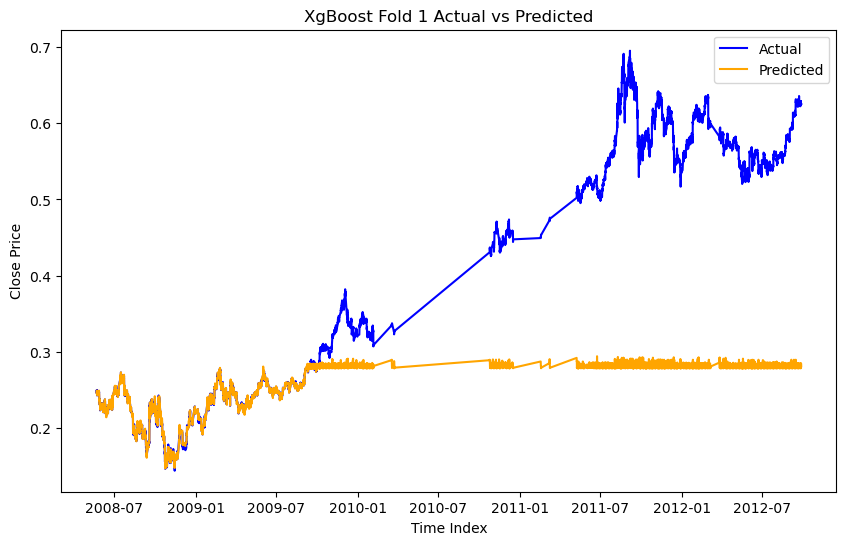

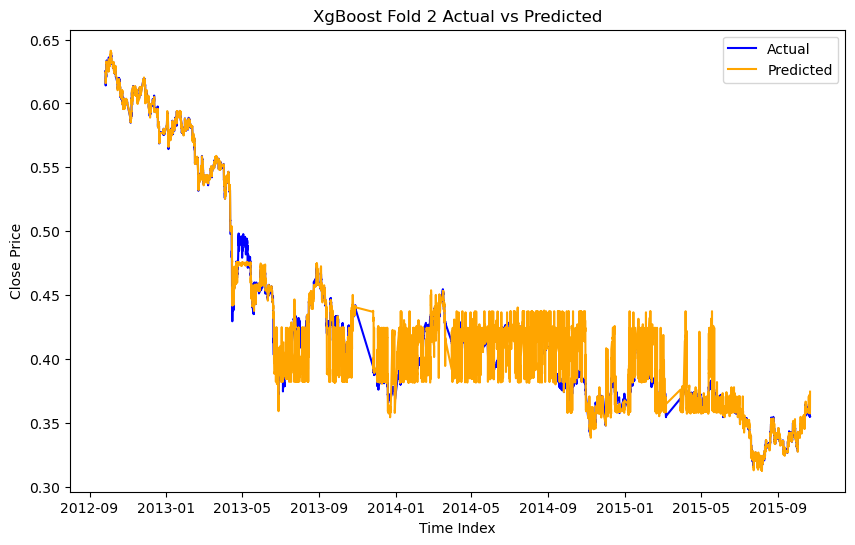

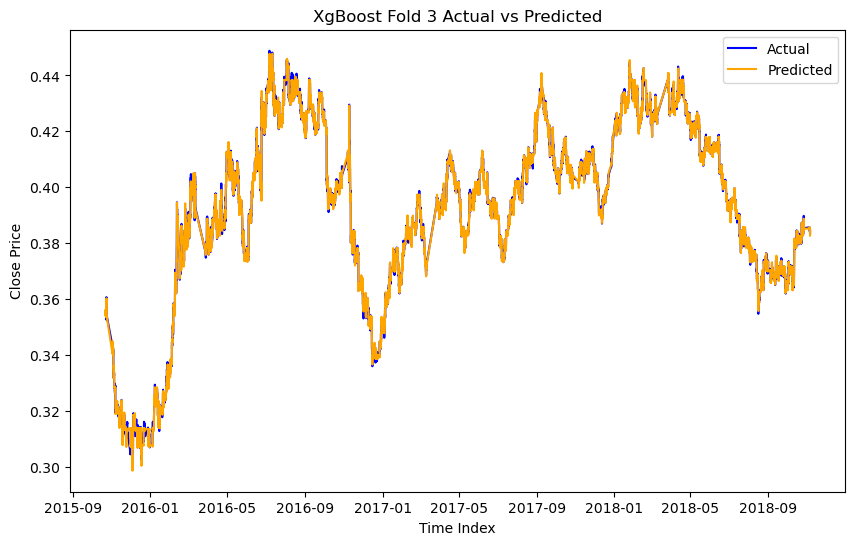

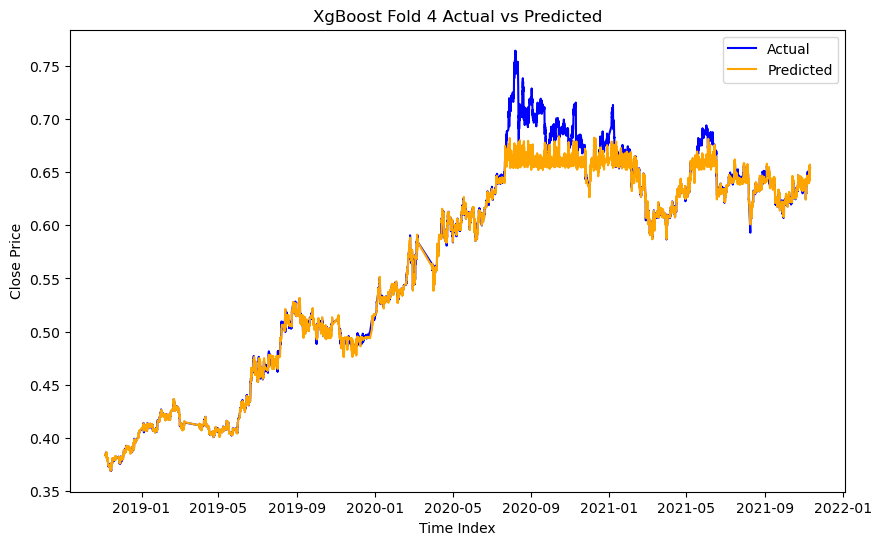

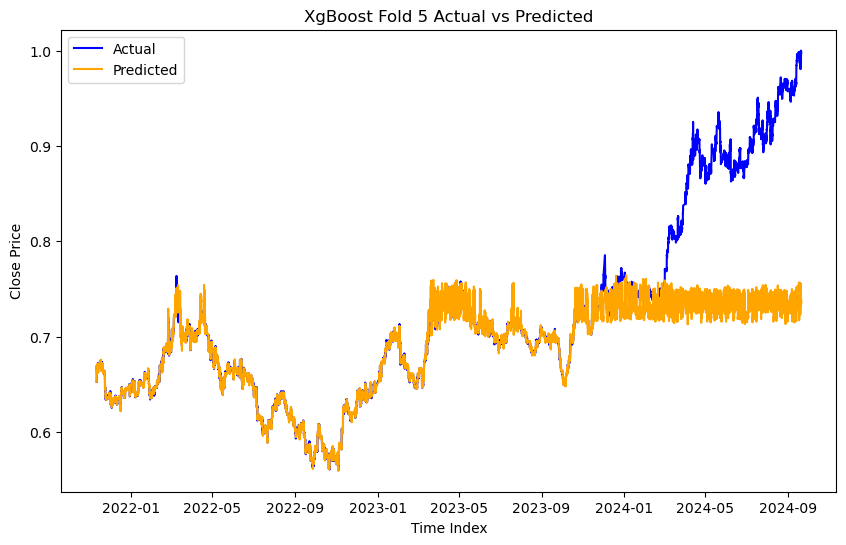

In [277]:
#comparing fold results with the actual to analyse if some saw more error due to volatality 
fold_results_df = pd.concat(fold_results, ignore_index=True)
for fold in fold_results_df['Fold'].unique():
    fold_data = fold_results_df[fold_results_df['Fold'] == fold]
    plt.figure(figsize=(10, 6))
    plt.plot(fold_data['Index'], fold_data['Actual'], label='Actual', color='blue')
    plt.plot(fold_data['Index'], fold_data['Predicted'], label='Predicted', color='orange')
    plt.title(f'XgBoost Fold {fold} Actual vs Predicted')
    plt.xlabel('Time Index')
    plt.ylabel('Close Price')
    plt.legend()
    save_path = f"/Users/abhisheksuga/Documents/Edu/thesis/gold/figures/XgBoost_Fold_{fold}.pdf"
    plt.savefig(save_path)
    plt.show()

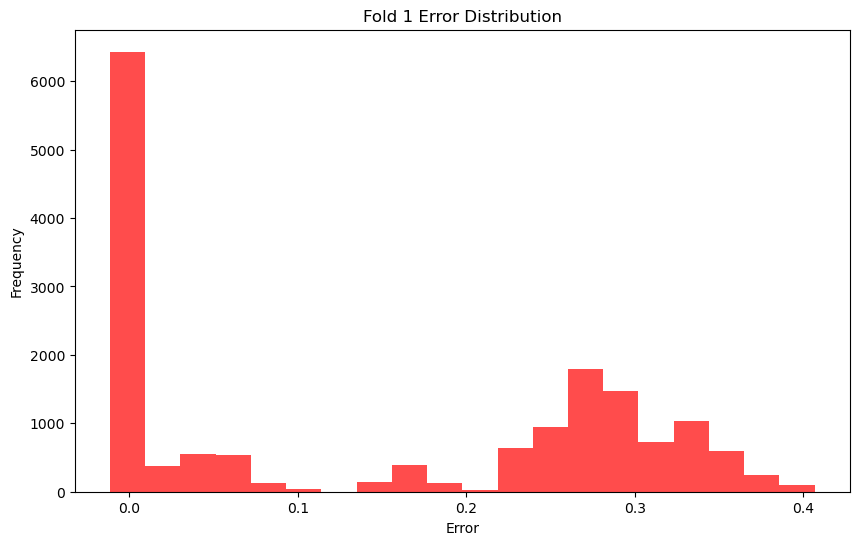

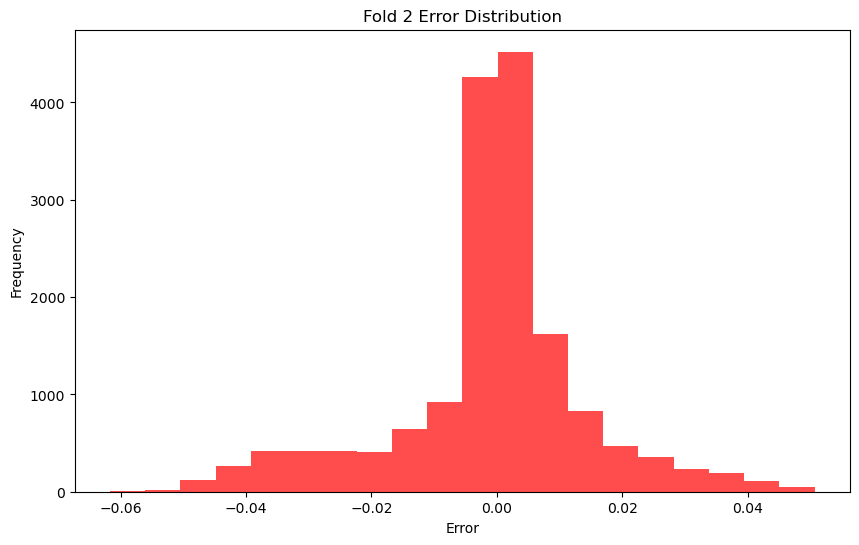

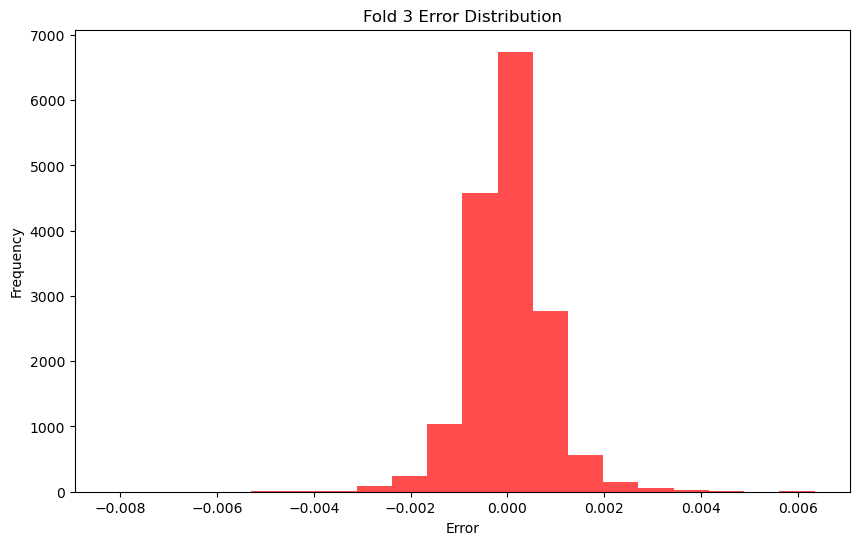

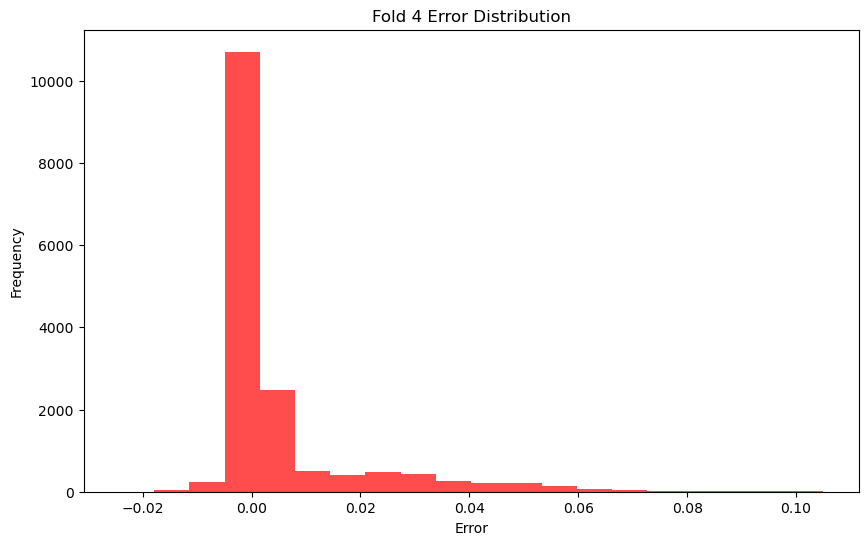

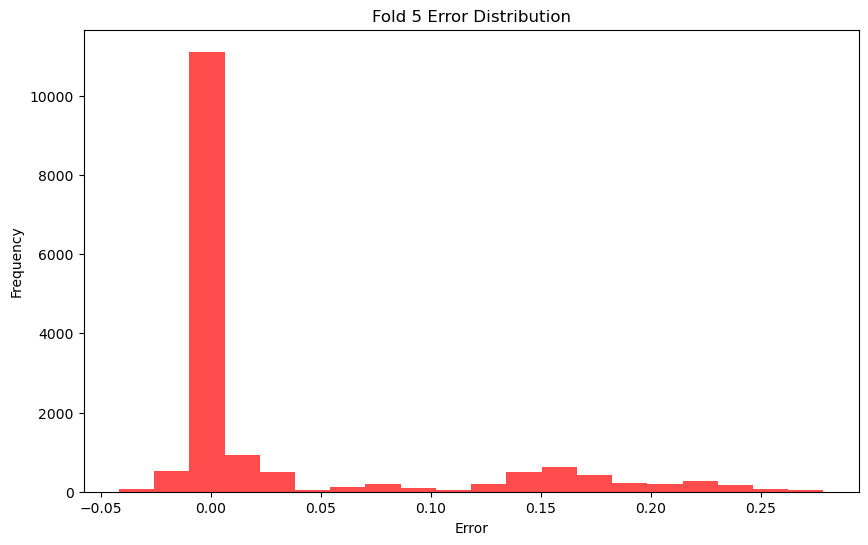

In [249]:
#prediction error check

fold_results_df['Error'] = fold_results_df['Actual'] - fold_results_df['Predicted']

for fold in fold_results_df['Fold'].unique():
    fold_data = fold_results_df[fold_results_df['Fold'] == fold]
    plt.figure(figsize=(10, 6))
    plt.hist(fold_data['Error'], bins=20, color='red', alpha=0.7)
    plt.title(f'Fold {fold} Error Distribution')
    plt.xlabel('Error')
    plt.ylabel('Frequency')
    plt.show()


In [250]:
#fold specific data distribution 

for fold in fold_results_df['Fold'].unique():
    fold_data = fold_results_df[fold_results_df['Fold'] == fold]
    print(f"Fold {fold} Statistics:")
    print(fold_data.describe())


Fold 1 Statistics:
          Fold        Actual     Predicted                          Index  \
count  16299.0  16299.000000  16299.000000                          16299   
mean       1.0      0.409457      0.261868  2010-08-12 22:22:54.268359936   
min        1.0      0.144118      0.147078            2008-05-21 18:00:00   
25%        1.0      0.246320      0.246339            2009-04-02 21:30:00   
50%        1.0      0.433364      0.279078            2010-11-01 02:00:00   
75%        1.0      0.564668      0.281824            2011-12-21 05:30:00   
max        1.0      0.694994      0.294276            2012-09-26 09:00:00   
std        0.0      0.164711      0.031639                            NaN   

              Error  
count  16299.000000  
mean       0.147589  
min       -0.011406  
25%        0.000241  
50%        0.152128  
75%        0.282720  
max        0.406720  
std        0.142128  
Fold 2 Statistics:
          Fold        Actual     Predicted                          In

/var/folders/bz/q_7jbqjx7hj_vffhkj3cyl_m0000gn/T/ipykernel_11060/1415721011.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fold_data['Rolling Mean'] = fold_data['Actual'].rolling(window=5).mean()


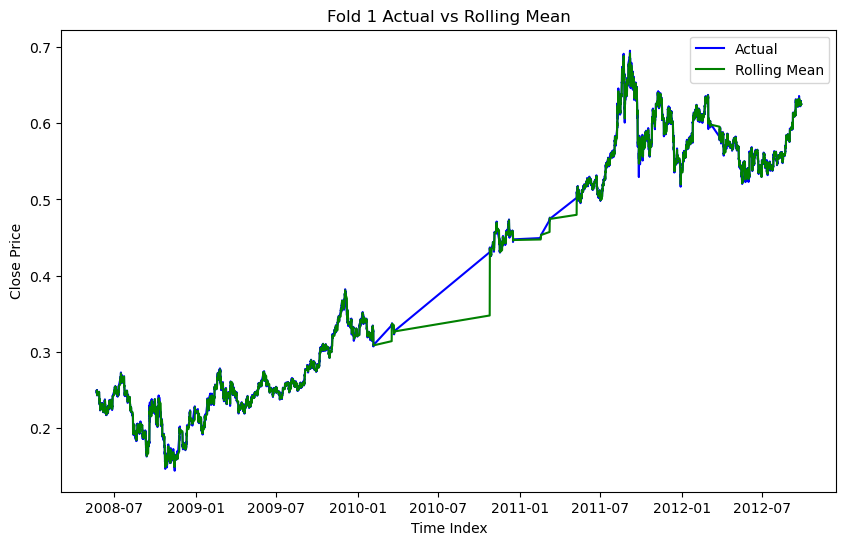

/var/folders/bz/q_7jbqjx7hj_vffhkj3cyl_m0000gn/T/ipykernel_11060/1415721011.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fold_data['Rolling Mean'] = fold_data['Actual'].rolling(window=5).mean()


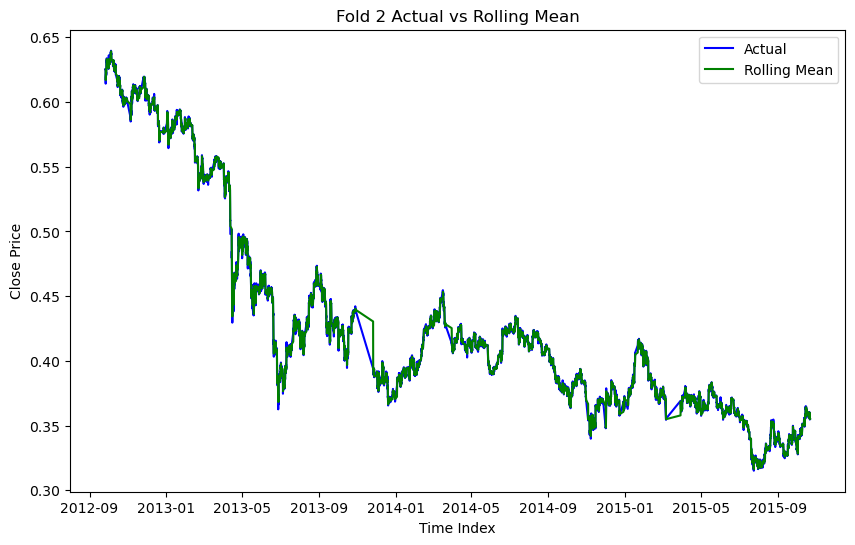

/var/folders/bz/q_7jbqjx7hj_vffhkj3cyl_m0000gn/T/ipykernel_11060/1415721011.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fold_data['Rolling Mean'] = fold_data['Actual'].rolling(window=5).mean()


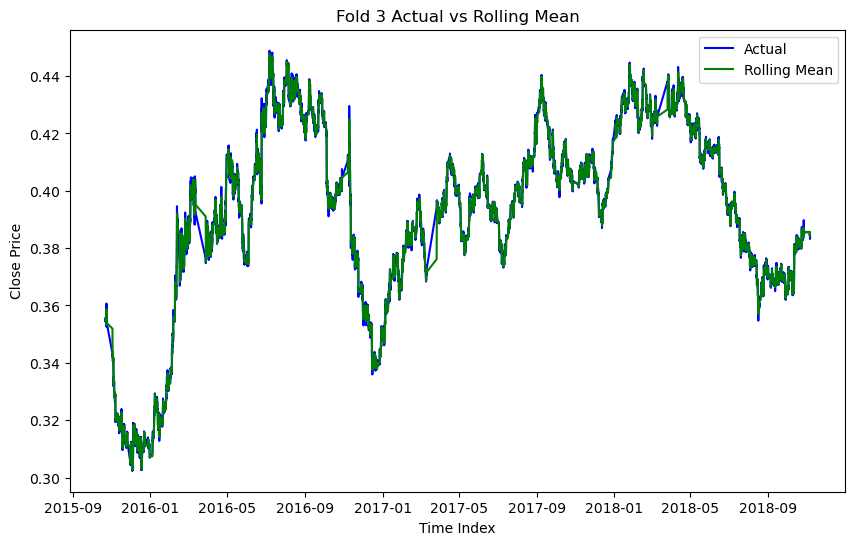

/var/folders/bz/q_7jbqjx7hj_vffhkj3cyl_m0000gn/T/ipykernel_11060/1415721011.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fold_data['Rolling Mean'] = fold_data['Actual'].rolling(window=5).mean()


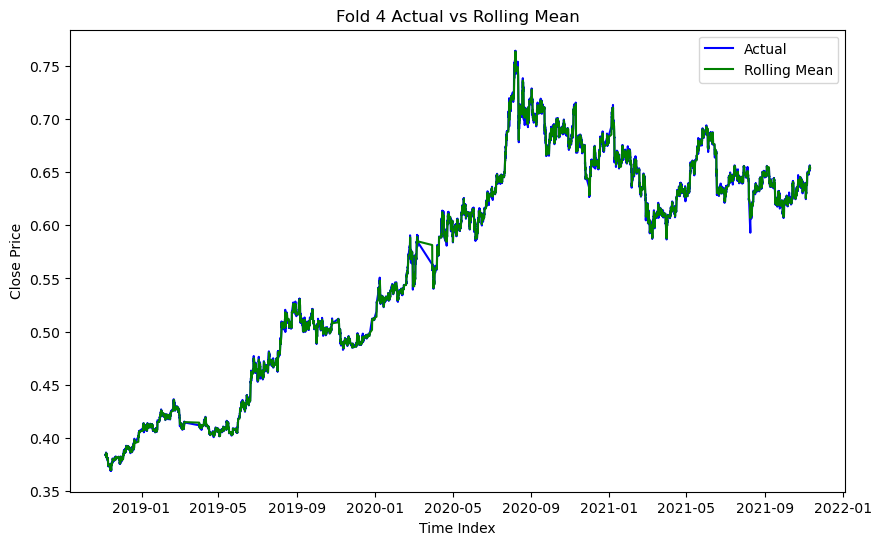

/var/folders/bz/q_7jbqjx7hj_vffhkj3cyl_m0000gn/T/ipykernel_11060/1415721011.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fold_data['Rolling Mean'] = fold_data['Actual'].rolling(window=5).mean()


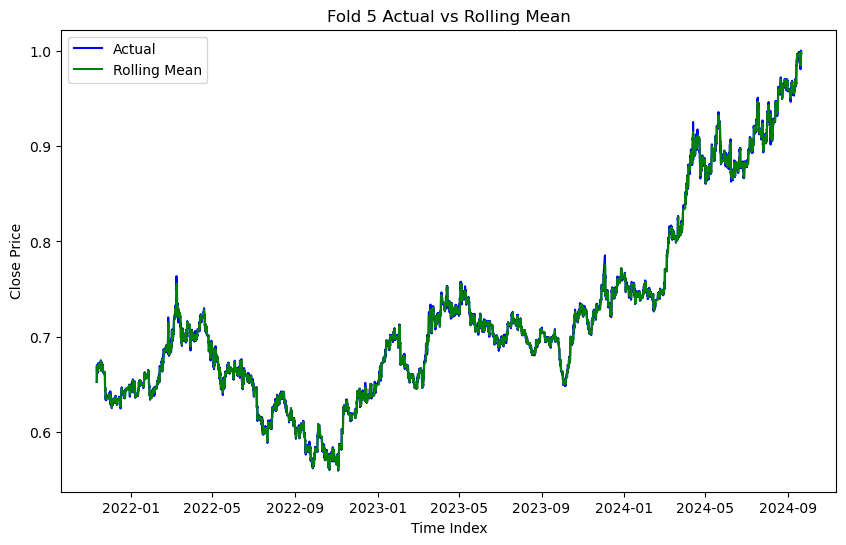

In [251]:
for fold in fold_results_df['Fold'].unique():
    fold_data = fold_results_df[fold_results_df['Fold'] == fold]
    fold_data['Rolling Mean'] = fold_data['Actual'].rolling(window=5).mean()
    plt.figure(figsize=(10, 6))
    plt.plot(fold_data['Index'], fold_data['Actual'], label='Actual', color='blue')
    plt.plot(fold_data['Index'], fold_data['Rolling Mean'], label='Rolling Mean', color='green')
    plt.title(f'Fold {fold} Actual vs Rolling Mean')
    plt.xlabel('Time Index')
    plt.ylabel('Close Price')
    plt.legend()
    plt.show()


Understanding from the experiment is that :
1. The period from 2008 to 2012 includes the global financial crisis, which likely caused unusual volatility and structural changes in market behavior, making it harder to predict.
2. Rolling  mean vs actual suugests the volatality that the model failed to understand 
3. Confirmed From all the metrics we confirm  that fold one is underperforming signaling anomalies, non-stationarity, or distribution shifts.


Next move reasons :
1. Dataset has long-term dependencies / non-linear relationships that XGBoost struggles to capture (e.g., the 2008–2012 period anomalies), deep learning models like LSTMs or GRUs are better suited for such tasks.
2. Deep learning models are more suited to learn such patterns without the need of feature engineering .
3.  Since our dataset is huge , its more helpful for deep learning models .

In [252]:
df_2.head()

,Open,High,Low,Close,Volume
DateTime,,,,,
2004-06-14 01:00:00,0.001357,0.001127,0.001133,0.000814,0.000066
2004-06-14 02:00:00,0.001357,0.001037,0.000544,0.000543,0.000357
2004-06-14 03:00:00,0.000679,0.000586,0.000544,0.000362,0.000308
2004-06-14 04:00:00,0.000588,0.000586,0.000680,0.000543,0.000272
2004-06-14 05:00:00,0.000679,0.000586,0.000770,0.000543,0.000097


In [253]:
df_2[:-1]

,Open,High,Low,Close,Volume
DateTime,,,,,
2004-06-14 01:00:00,0.001357,0.001127,0.001133,0.000814,0.000066
2004-06-14 02:00:00,0.001357,0.001037,0.000544,0.000543,0.000357
2004-06-14 03:00:00,0.000679,0.000586,0.000544,0.000362,0.000308
2004-06-14 04:00:00,0.000588,0.000586,0.000680,0.000543,0.000272
2004-06-14 05:00:00,0.000679,0.000586,0.000770,0.000543,0.000097
...,...,...,...,...,...
2024-09-19 18:00:00,0.995214,0.995203,0.996597,0.998760,0.242595
2024-09-19 19:00:00,0.998760,0.996605,0.999896,0.999941,0.167619
2024-09-19 20:00:00,0.999932,0.996659,1.000000,0.999425,0.108959


### 3.2 LSTM model

In [255]:
#LSTM implementation 
df_2 = filtered_data.copy()
df_2 = df_2.drop(columns=['Hour','Date'])
look_back = 23  # Using the past 23 hours to predict 

data = df_2[['Open', 'High', 'Low', 'Close', 'Volume']].values


# to create sequence 
def create_sequences(data, look_back):
    X, y = [], []
    for i in range(look_back, len(data)):
        # Slice the rows for the look-back period
        window = data[i-look_back:i, :]  # Select all columns initially
        # Select specific columns for features: Open, High, Low, Volume (indices 0, 1, 2, 4)
        X.append(window[:, [0, 1, 2, 4]])  
        # Select the Close column (index 3) as the target variable
        y.append(data[i, 3])  # Close
    return np.array(X), np.array(y)

In [256]:
X, y = create_sequences(data, look_back=look_back)

In [258]:
# X.shape
y.shape

(97796,)

In [260]:
original_indices = df_1.index #storing indices so that i can use even after converting series to numpy array 
original_indices

DatetimeIndex(['2004-06-14 23:00:00', '2004-06-15 01:00:00',
               '2004-06-15 02:00:00', '2004-06-15 03:00:00',
               '2004-06-15 04:00:00', '2004-06-15 05:00:00',
               '2004-06-15 06:00:00', '2004-06-15 07:00:00',
               '2004-06-15 08:00:00', '2004-06-15 09:00:00',
               ...
               '2024-09-19 14:00:00', '2024-09-19 15:00:00',
               '2024-09-19 16:00:00', '2024-09-19 17:00:00',
               '2024-09-19 18:00:00', '2024-09-19 19:00:00',
               '2024-09-19 20:00:00', '2024-09-19 21:00:00',
               '2024-09-19 22:00:00', '2024-09-19 23:00:00'],
              dtype='datetime64[ns]', name='DateTime', length=97797, freq=None)

In [265]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np
import pandas as pd

fold_results = []

for fold, (train_index, test_index) in enumerate(fold_indices):  # Using the same splits as XGBoost
    test_index = test_index[test_index < len(X)]

    # Reshape input for LSTM
    X_train = X[train_index].reshape(-1, 23, 4)  
    X_test = X[test_index].reshape(-1, 23, 4)
    y_train = y[train_index].flatten()  
    y_test = y[test_index].flatten()
    
    # LSTM Model
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=(23, 4)))
    model.add(Dropout(0.2))
    model.add(LSTM(50, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    
 
    model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)
    
    # Evaluate
    y_pred = model.predict(X_test).flatten()  
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    smape_value = smape(y_test, y_pred)
    
    print(f"Fold {fold + 1} Metrics:")
    print(f" - RMSE: {rmse:.4f}")
    print(f" - R-Squared: {r2:.4f}")
    print(f" - Mean Absolute Error: {mae:.4f}")
    print(f" - sMAPE: {smape_value:.2f}%")

    fold_results.append(pd.DataFrame({
        'Fold': fold + 1,
        'Actual': y_test,
        'Predicted': y_pred,
        'Index': original_indices[test_index]
    }))


/Users/abhisheksuga/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


510/510 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
Fold 1 Metrics:
 - RMSE: 0.0094
 - R-Squared: 0.9967
 - Mean Absolute Error: 0.0070
 - sMAPE: 1.48%


/Users/abhisheksuga/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


510/510 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step
Fold 2 Metrics:
 - RMSE: 0.0078
 - R-Squared: 0.9907
 - Mean Absolute Error: 0.0065
 - sMAPE: 1.45%


/Users/abhisheksuga/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


510/510 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
Fold 3 Metrics:
 - RMSE: 0.0020
 - R-Squared: 0.9961
 - Mean Absolute Error: 0.0014
 - sMAPE: 0.36%


/Users/abhisheksuga/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


510/510 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
Fold 4 Metrics:
 - RMSE: 0.0037
 - R-Squared: 0.9987
 - Mean Absolute Error: 0.0027
 - sMAPE: 0.45%


/Users/abhisheksuga/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


510/510 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step
Fold 5 Metrics:
 - RMSE: 0.0155
 - R-Squared: 0.9757
 - Mean Absolute Error: 0.0087
 - sMAPE: 1.06%


In [264]:
print(f"X size: {len(X)}, y size: {len(y)}")


X size: 97796, y size: 97796


## Results of LSTM 

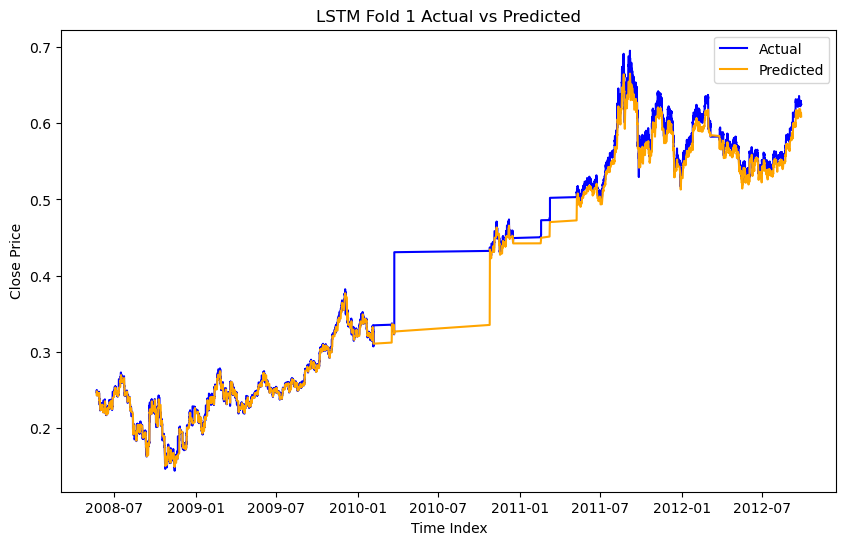

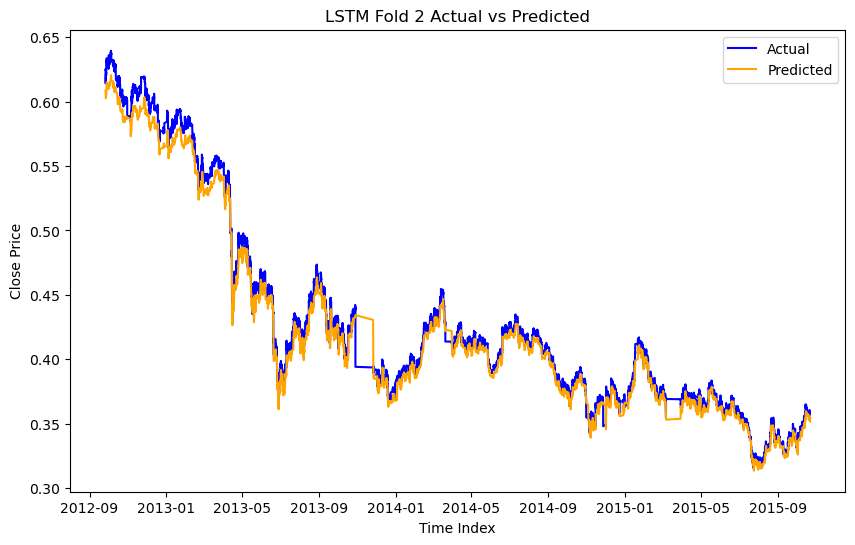

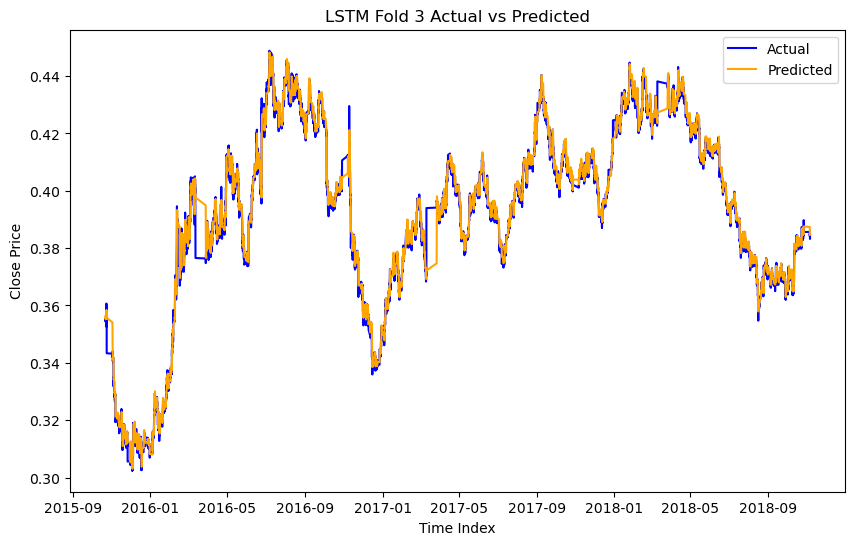

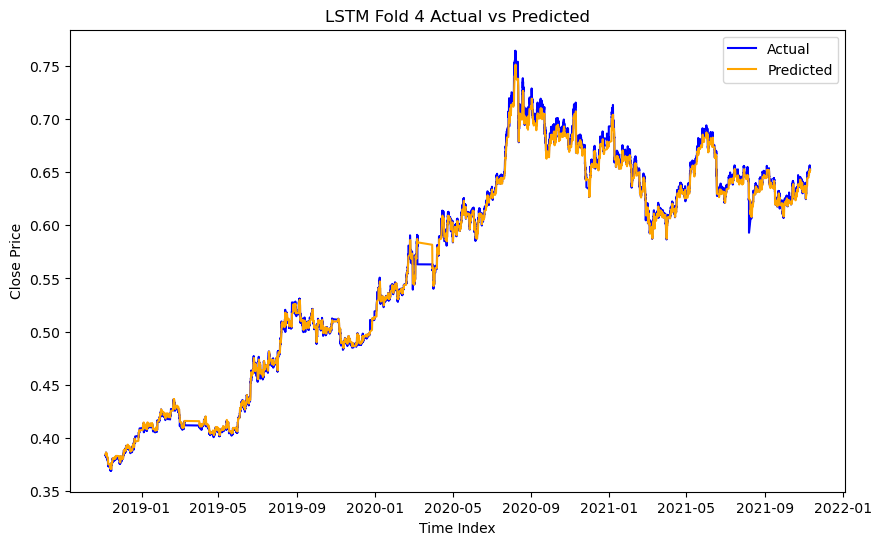

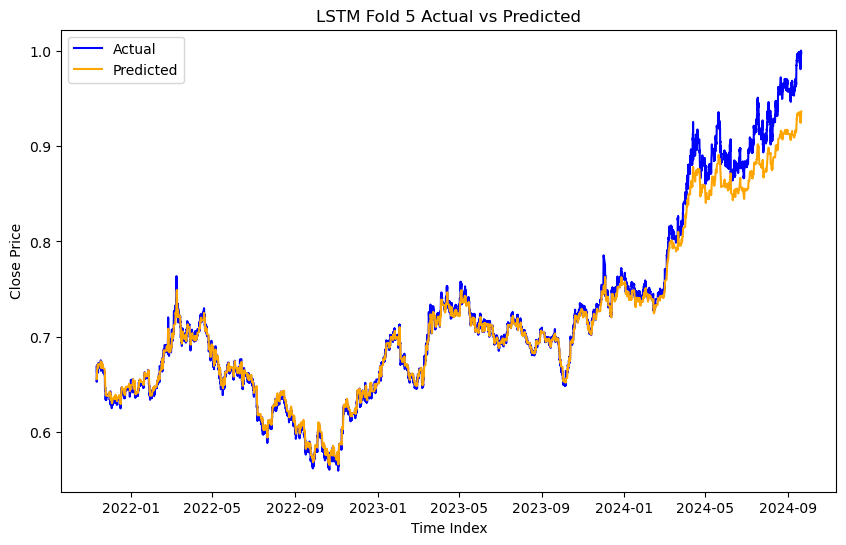

In [274]:
fold_results_df1 = pd.concat(fold_results, ignore_index=True)

for fold in fold_results_df1['Fold'].unique():  # Fixed from fold_results['Fold']
    fold_data = fold_results_df1[fold_results_df1['Fold'] == fold]
    plt.figure(figsize=(10, 6))
    plt.plot(fold_data['Index'], fold_data['Actual'], label='Actual', color='blue')  # Ensure Index is valid
    plt.plot(fold_data['Index'], fold_data['Predicted'], label='Predicted', color='orange')
    plt.title(f'LSTM Fold {fold} Actual vs Predicted')
    plt.xlabel('Time Index')
    plt.ylabel('Close Price')
    plt.legend()
    save_path = f"/Users/abhisheksuga/Documents/Edu/thesis/gold/figures/LSTM_Fold_{fold}.pdf"
    plt.savefig(save_path)
    plt.show()


## Observation from LSTM results

1. We did not use any other features like we used in Xgboost , because LSTM is inherently capable of learning from the sequential data unlike xgboost
2. We wanted to test the strength of LSTM 
3. The LSTM model demonstrates strong generalisation and performs consistently across folds, except for slight dips in Fold 5.

In [288]:
crude_data = pd.read_csv("/Users/abhisheksuga/Documents/Edu/thesis/gold/data/crudeOil.csv")

In [289]:
crude_data.head()

,01/04/2007;18:00:00;65.71;65.75;65.52;65.52;467
0,01/04/2007;19:00:00;65.53;65.88;65.53;65.88;598
1,01/04/2007;20:00:00;65.88;65.99;65.79;65.9;631
2,01/04/2007;21:00:00;65.91;65.98;65.78;65.8;376
3,01/04/2007;22:00:00;65.78;65.82;65.64;65.81;261
4,01/04/2007;23:00:00;65.77;65.81;65.73;65.74;76


In [292]:
crude_data.columns = ['Timestamp', 'Open', 'High', 'Low', 'Close', 'Volume']
crude_data.columns

Index(['01/04/2007;18:00:00;65.71;65.75;65.52;65.52;467'], dtype='object')

In [299]:



crude_data = pd.read_csv('/Users/abhisheksuga/Documents/Edu/thesis/gold/data/crudeOil.csv', header=None, sep=';')

crude_data.columns = ['Date','Time','Open', 'High', 'Low', 'Crude_Close', 'Crude_Volume']



In [298]:
print(crude_data.shape)

(105714, 7)


In [303]:
crude_data.head()

,Date,Time,Open,High,Low,Close,Volume
0,01/04/2007,18:00:00,65.71,65.75,65.52,65.52,467
1,01/04/2007,19:00:00,65.53,65.88,65.53,65.88,598
2,01/04/2007,20:00:00,65.88,65.99,65.79,65.90,631
3,01/04/2007,21:00:00,65.91,65.98,65.78,65.80,376
4,01/04/2007,22:00:00,65.78,65.82,65.64,65.81,261


In [305]:
crude_data.isnull().sum()

Date      0
Time      0
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

In [307]:
crude_data['DateTime'] = pd.to_datetime(crude_data['Date'] + ' ' + crude_data['Time'],format='%d/%m/%Y %H:%M:%S')
crude_data.set_index('DateTime', inplace=True)
crude_data.drop(['Date', 'Time'], axis=1, inplace=True)


In [322]:

crude_data.rename(columns={'Close': 'Crude_Close', 'Volume': 'Crude_Volume'}, inplace=True)


In [325]:

to_scale = ['Crude_Close', 'Crude_Volume']
crude_data[to_scale] = scaler.fit_transform(crude_data[to_scale])

In [326]:
crude_data.head()

,Open,High,Low,Crude_Close,Crude_Volume
DateTime,,,,,
2007-04-01 18:00:00,65.71,65.75,65.52,0.408703,0.001434
2007-04-01 19:00:00,65.53,65.88,65.53,0.411327,0.001837
2007-04-01 20:00:00,65.88,65.99,65.79,0.411473,0.001938
2007-04-01 21:00:00,65.91,65.98,65.78,0.410744,0.001154
2007-04-01 22:00:00,65.78,65.82,65.64,0.410817,0.000800


In [327]:
df_1.head()

,Open,High,Low,Close,Volume,Hour,Date,Close_lag_1,Close_lag_3,Close_lag_10,Close_lag_20,rolling_mean_close,rolling_std_close
DateTime,,,,,,,,,,,,,
2004-06-14 23:00:00,0.000679,0.000496,0.000680,0.000452,0.000115,23,2004-06-14,0.000362,0.000452,0.000588,0.000362,0.000541,0.000281
2004-06-15 01:00:00,0.000679,0.000586,0.000680,0.000452,0.000060,1,2004-06-15,0.000452,0.000452,0.001131,0.000543,0.000525,0.000275
2004-06-15 02:00:00,0.000905,0.000721,0.000544,0.000679,0.000357,2,2004-06-15,0.000452,0.000362,0.001267,0.000543,0.000531,0.000277
2004-06-15 03:00:00,0.000905,0.000812,0.000634,0.000317,0.000278,3,2004-06-15,0.000679,0.000452,0.001041,0.000452,0.000529,0.000278
2004-06-15 04:00:00,0.000452,0.000361,0.000453,0.000362,0.000199,4,2004-06-15,0.000317,0.000452,0.000452,0.000362,0.000521,0.000281


In [328]:
combined_1 = df_1.join(crude_data[['Crude_Close', 'Crude_Volume']], how='inner')

In [330]:
combined_1.head()

,Open,High,Low,Close,Volume,Hour,Date,Close_lag_1,Close_lag_3,Close_lag_10,Close_lag_20,rolling_mean_close,rolling_std_close,Crude_Close,Crude_Volume
DateTime,,,,,,,,,,,,,,,
2007-04-02 01:00:00,0.128116,0.127908,0.128377,0.128372,0.000568,1,2007-04-02,0.126471,0.126697,0.125838,0.128191,0.127221,0.001016,0.410088,0.000477
2007-04-02 02:00:00,0.128613,0.127863,0.128014,0.127602,0.000816,2,2007-04-02,0.128372,0.126335,0.126381,0.128236,0.127195,0.000998,0.406662,0.005686
2007-04-02 03:00:00,0.127844,0.127322,0.128014,0.127874,0.000375,3,2007-04-02,0.127602,0.126471,0.125702,0.128145,0.127181,0.000985,0.406371,0.004729
2007-04-02 04:00:00,0.128025,0.127277,0.128059,0.127648,0.000066,4,2007-04-02,0.127874,0.128372,0.125159,0.127919,0.127158,0.000966,0.410161,0.007055
2007-04-02 05:00:00,0.127890,0.127142,0.127969,0.127648,0.000338,5,2007-04-02,0.127648,0.127602,0.126607,0.127829,0.127132,0.000944,0.409578,0.005279


In [344]:
len(nasdaq_data)

117

In [341]:
nasdaq_data['Datetime'] = pd.to_datetime(nasdaq_data['<DATE>'] + ' ' + nasdaq_data['<TIME>'])

nasdaq_data.set_index('Datetime', inplace=True)

In [347]:
snp500_data.head()

,<DATE>,<TIME>,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<TICKVOL>,<VOL>,<SPREAD>
0,2004.01.01,03:00:00,1110.13,1111.91,1110.13,1111.91,179,0,0
1,2004.01.02,03:00:00,1112.61,1118.70,1105.02,1108.48,2324,0,0
2,2004.01.03,03:00:00,1107.82,1108.48,1107.82,1108.48,67,0,0
3,2004.01.05,03:00:00,1112.35,1122.22,1112.35,1122.22,988,0,0
4,2004.01.06,03:00:00,1120.74,1124.44,1118.52,1123.67,892,0,0


In [348]:
snp500_data['Datetime'] = pd.to_datetime(snp500_data['<DATE>'] + ' ' + snp500_data['<TIME>'])

snp500_data.set_index('Datetime', inplace=True)

## Xgboost implementation with additional features such as crude_oil close prices AND Volume

In [352]:

X = combined_1.drop(columns=['Close','Date','Hour'])
y = combined_1['Close']

#using timeseries split to main chorology and also cross validates with splits 
tscv = TimeSeriesSplit(n_splits=5)
fold_results = []

#udf for calculating symmetric mape which is more robust for small values (scaled) , Also used in financial data due to near zero / anomolies 
def smape(y_true, y_pred):
    return 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))
fold_indices =[]

for fold, (train_index, test_index) in enumerate(tscv.split(X)):
    fold_indices.append((train_index, test_index))
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Train the model
    model = xgb.XGBRegressor(objective='reg:squarederror')
    model.fit(X_train, y_train)
    
    # RMSE
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f"Fold {fold + 1} RMSE: {rmse:.4f}")
   
    # R-Squared
    r2 = r2_score(y_test, y_pred)
    print(f"Fold {fold + 1} R-Squared: {r2:.4f}")
    
    #MAE
    mae = mean_absolute_error(y_test, y_pred)
    print(f"Fold {fold + 1} Mean Absolute Error: {mae:.4f}")

    #sMAPE
    smape_value = smape(y_test.values, y_pred)
    print(f"Fold {fold + 1}  sMAPE: {smape_value:.2f}%")

    
    # Store the fold's results
    fold_results.append(pd.DataFrame({
        'Fold': fold + 1,
        'Actual': y_test.values,
        'Predicted': y_pred,
        'Index': y_test.index
    }))


Fold 1 RMSE: 0.1270
Fold 1 R-Squared: -2.3528
Fold 1 Mean Absolute Error: 0.1100
Fold 1  sMAPE: 21.72%
Fold 2 RMSE: 0.0028
Fold 2 R-Squared: 0.9934
Fold 2 Mean Absolute Error: 0.0020
Fold 2  sMAPE: 0.54%
Fold 3 RMSE: 0.0006
Fold 3 R-Squared: 0.9994
Fold 3 Mean Absolute Error: 0.0004
Fold 3  sMAPE: 0.11%
Fold 4 RMSE: 0.0126
Fold 4 R-Squared: 0.9710
Fold 4 Mean Absolute Error: 0.0063
Fold 4  sMAPE: 0.95%
Fold 5 RMSE: 0.0819
Fold 5 R-Squared: 0.3417
Fold 5 Mean Absolute Error: 0.0405
Fold 5  sMAPE: 5.03%


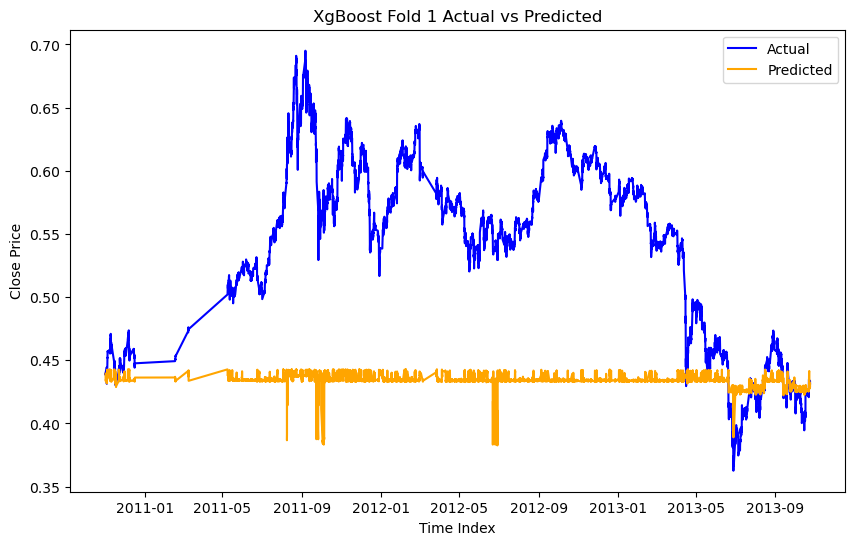

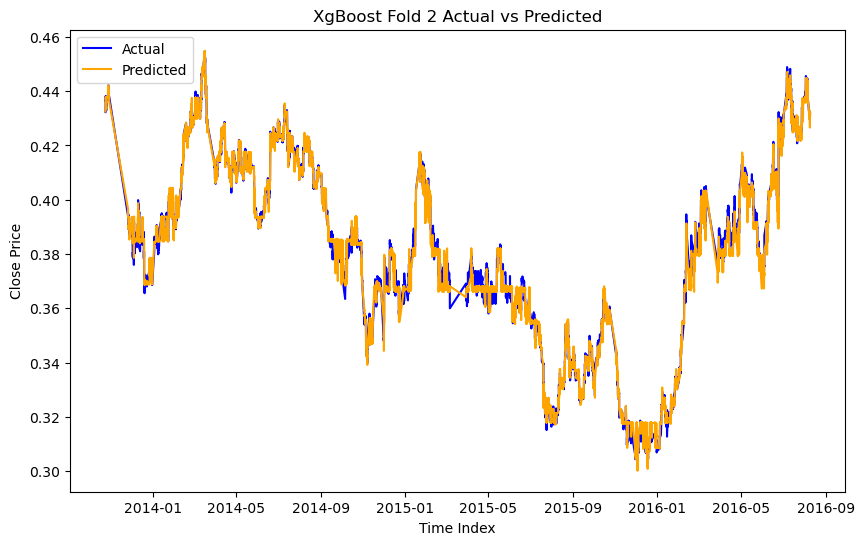

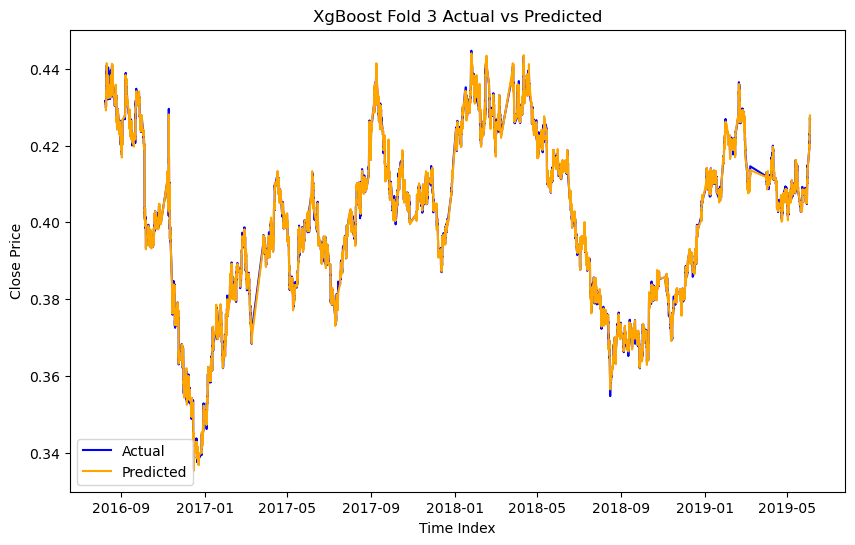

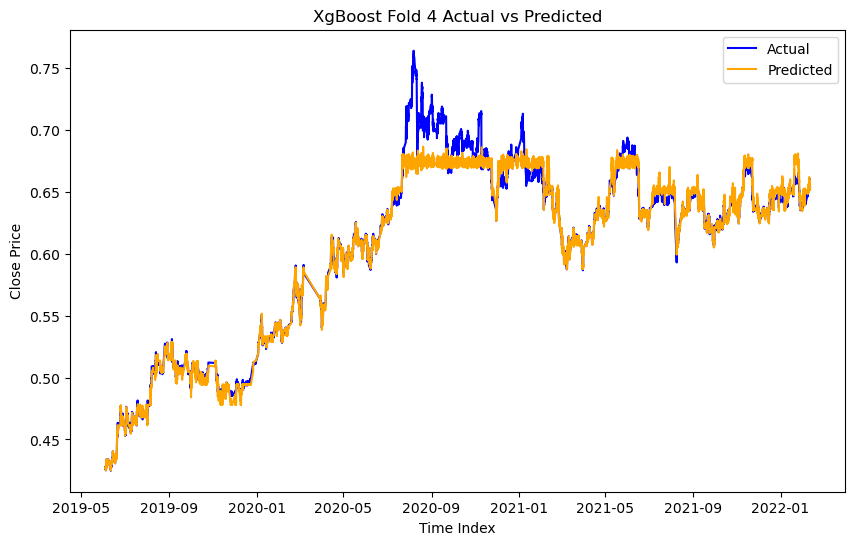

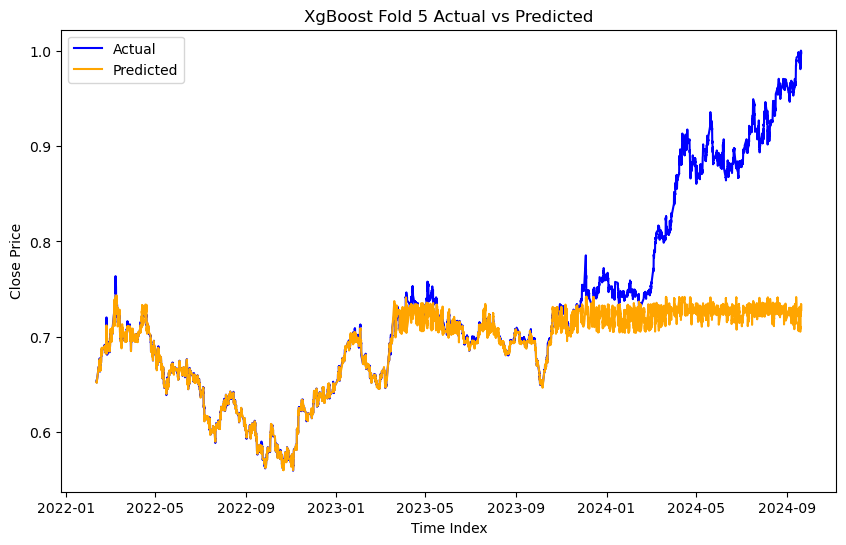

In [353]:

fold_results_crude = pd.concat(fold_results, ignore_index=True)
for fold in fold_results_crude['Fold'].unique():
    fold_data = fold_results_crude[fold_results_crude['Fold'] == fold]
    plt.figure(figsize=(10, 6))
    plt.plot(fold_data['Index'], fold_data['Actual'], label='Actual', color='blue')
    plt.plot(fold_data['Index'], fold_data['Predicted'], label='Predicted', color='orange')
    plt.title(f'XgBoost Fold {fold} Actual vs Predicted')
    plt.xlabel('Time Index')
    plt.ylabel('Close Price')
    plt.legend()
    save_path = f"/Users/abhisheksuga/Documents/Edu/thesis/gold/figures/XgBoost_Fold_{fold}.pdf"
    plt.savefig(save_path)
    plt.show()

In [359]:
train_index = train_index[train_index < len(X)]
test_index = test_index[test_index < len(X)]

## Lstm implementation with crude oil price data added 

In [361]:
print(f"Shape of X: {X.shape}")
print(f"Train Index: {train_index}, Test Index: {test_index}")
print(f"Train Index Max: {max(train_index)}, Test Index Max: {max(test_index)}")


Shape of X: (80145, 12)
Train Index: [    0     1     2 ... 13357 13358 13359], Test Index: [13360 13361 13362 ... 26714 26715 26716]
Train Index Max: 13359, Test Index Max: 26716


In [362]:
print(f"Train Index Min: {min(train_index)}, Max: {max(train_index)}")
print(f"Test Index Min: {min(test_index)}, Max: {max(test_index)}")
print(f"X Shape: {X.shape}")


Train Index Min: 0, Max: 13359
Test Index Min: 13360, Max: 26716
X Shape: (80145, 12)


## LSTM with additional crudeoil price dataset

In [363]:



look_back = 23

def create_sequences(X, y, look_back):
    X_seq, y_seq = [], []
    for i in range(look_back, len(X)):
        X_seq.append(X[i - look_back:i, :])
        y_seq.append(y[i])
    return np.array(X_seq), np.array(y_seq)

X = combined_1.drop(columns=['Close', 'Date', 'Hour']).values  
y = combined_1['Close'].values

# Initialize TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)
fold_results = []



In [364]:

for fold, (train_index, test_index) in enumerate(tscv.split(X)):
    train_index = train_index[train_index >= look_back]
    test_index = test_index[test_index >= look_back]

    X_train, y_train = create_sequences(X[train_index], y[train_index], look_back)
    X_test, y_test = create_sequences(X[test_index], y[test_index], look_back)

    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=(look_back, X.shape[1])))
    model.add(Dropout(0.2))
    model.add(LSTM(50, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')


    model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)

    y_pred = model.predict(X_test).flatten()
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    smape_value = 100 * np.mean(2 * np.abs(y_pred - y_test) / (np.abs(y_test) + np.abs(y_pred)))

    print(f"Fold {fold + 1} Metrics:")
    print(f" - RMSE: {rmse:.4f}")
    print(f" - R-Squared: {r2:.4f}")
    print(f" - Mean Absolute Error: {mae:.4f}")
    print(f" - sMAPE: {smape_value:.2f}%")

    fold_results.append(pd.DataFrame({
        'Fold': fold + 1,
        'Actual': y_test,
        'Predicted': y_pred
    }))


/Users/abhisheksuga/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


417/417 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
Fold 1 Metrics:
 - RMSE: 0.0108
 - R-Squared: 0.9756
 - Mean Absolute Error: 0.0100
 - sMAPE: 1.89%


/Users/abhisheksuga/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


417/417 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
Fold 2 Metrics:
 - RMSE: 0.0090
 - R-Squared: 0.9310
 - Mean Absolute Error: 0.0086
 - sMAPE: 2.25%


/Users/abhisheksuga/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


417/417 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
Fold 3 Metrics:
 - RMSE: 0.0027
 - R-Squared: 0.9851
 - Mean Absolute Error: 0.0021
 - sMAPE: 0.54%


/Users/abhisheksuga/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


417/417 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
Fold 4 Metrics:
 - RMSE: 0.0048
 - R-Squared: 0.9958
 - Mean Absolute Error: 0.0040
 - sMAPE: 0.68%


/Users/abhisheksuga/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


417/417 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
Fold 5 Metrics:
 - RMSE: 0.0307
 - R-Squared: 0.9076
 - Mean Absolute Error: 0.0198
 - sMAPE: 2.46%


In [366]:

fold_results_lstm = pd.concat(fold_results, ignore_index=True)

for fold in fold_results_lstm['Fold'].unique():
    fold_data = fold_results_lstm[fold_results_lstm['Fold'] == fold]
    plt.figure(figsize=(10, 6))
 
    plt.plot(fold_data['Index'], fold_data['Actual'], label='Actual', color='blue')
    plt.plot(fold_data['Index'], fold_data['Predicted'], label='Predicted', color='orange')
    
    plt.title(f'LSTM Fold {fold} Actual vs Predicted')
    plt.xlabel('Time Index')
    plt.ylabel('Close Price')
    plt.legend()
    
    # Save the plot
    save_path = f"/Users/abhisheksuga/Documents/Edu/thesis/gold/figures/X_LSTM_Fold_{fold}.pdf"
    plt.savefig(save_path)
    plt.show()


KeyError: 'Index'

<Figure size 1000x600 with 0 Axes>